# Objetivo del proyecto

El objetivo es identificar perfiles socioeconómicos de altos ingresos. Para ello decidiremos que módelo de aprendizaje supervisado es más adecuado para nuestro objetivo.

# Obtención del dataset

Primero de todo importamos las librerías necesarias para trabajar

In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import optuna
import mlflow
import os
import warnings
import shap

Obtenemos el dataset

In [3]:
df = pd.read_csv('adult.csv')

In [4]:
# Para reproducibilidad
SEED = 42
np.random.seed(SEED)

# EDA

En esta sección vamos a analizar el dataset que vamos a utilizar. Entre otras cosas, analizaremos:
- Valores faltantes (Missings)
- Valores atípicos (Outliers)
- Valores duplicados
- Correlación entre variables

Primero de todo vamos a echar un vistazo rápido al dataset. Lo primero que podemos observar es que en ciertas columnas aparecen signos de interrogación. Estos los vamos a tratar como missings.

Por otro lado, podemos ver que las columnas education y education.num poseen información similar, y mantener ambas en el dataset podría ser redundante. Lo que haremos será quedarnos con education.num, ya que en cierto modo captura información sobre el orden jerárquico de la eduación (e.g., un Doctorado es mayor que un Grado).

Finalmente, eliminaremos la columna fnlwgt, ya que no representa ninguna información sobre los individuos. Es un dato estadístico extraído de las columnas 'race', 'age' y 'sex', según podemos ver en la web oficial del dataset.

In [5]:
# Eliminamos las columnas fnlwgt y education
df.drop('fnlwgt', axis=1, inplace=True)
df.drop('education', axis=1, inplace=True)

## Missings



Veamos primero de todo si hay datos vacíos (NaN) en nuestro dataframe.

In [6]:
df.isna().sum()

age               0
workclass         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

Vemos por tanto que no hay missings en nuestro dataset. Sin embargo, como vimos antes, hay signos de interrogación en alguna de las columnas. A priori tenemos 2 formas de tratarlos:


*   Eliminar las filas respectivas si no suponen un gran porcentaje del conjunto total
*   Reemplazarlos por la clase más frecuente de la columna o la media aritmética, dependiendo si la columna es categórica o numérica

Veamos primero el tamaño de nuestro dataset y el número de filas donde aparecen signos de interrogación


In [7]:
print(df.shape)
print((df == '?').sum())

(32561, 13)
age                  0
workclass         1836
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64


No parece haber muchas filas. No podemos simplemente sumar porque podríamos estar contando de más. Para ver el número exacto hacemos:

In [8]:
mask = (df == '?').any(axis=1)
mask.sum()

np.int64(2399)

El número de filas donde aparece un '?' supone más del 7% del dataset. Vamos a optar por inputar esos missings por la clase más frecuente, ya que las columnas donde aparecen son categóricas. Esto estará includído en el pipeline de preprocesamiento más adelante.

## Outliers

Para identificar outliers primero echaremos un vistazo a df.describe(), donde aparece información estadística sobre nuestros datos. Seguido de esto, usaremos el IQR (Rango intercuartílico) como medida para detectar la presencia de outliers.

In [9]:
df.describe()

,age,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,40.437456
std,13.640433,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


A priori podríamos pensar que en la columna capital.gain hay presencia de outliers, pues el máximo está muy alejado de la media. Sin embargo, lo que hace que la media tenga un valor tan bajo es que hay muchos 0 en dicha columna. Si recordamos, dicha columna representa las ganancias de capital, i.e, los ingresos provenientes de la venta de activos cuando se venden a un precio mayor al que fueron comprados.

In [10]:
num_cols = df.select_dtypes(include=['int64']).columns # Columnas numéricas

outliers = {}

for col in num_cols:
    Q1 = np.percentile(df[col], 25)
    Q3 = np.percentile(df[col], 75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    outliers[col] = df[mask]

    print(f"Columna: {col}")
    print(f"  Outliers encontrados: {mask.sum()}")
    print("-"*40)

Columna: age
  Outliers encontrados: 143
----------------------------------------
Columna: education.num
  Outliers encontrados: 1198
----------------------------------------
Columna: capital.gain
  Outliers encontrados: 2712
----------------------------------------
Columna: capital.loss
  Outliers encontrados: 1519
----------------------------------------
Columna: hours.per.week
  Outliers encontrados: 9008
----------------------------------------


Vemos que el método IQR para detectar outliers nos devuelve una gran cantidad de ellos. Sin embargo, vamos a decidir no modificar el dataset, ya que las columnas en las que estamos trabajando es normal la presencia de outliers. Por ejemplo, la mayoría de las personas no tienen ingresos fuera de su salario extra, y por dicho motivo la columna capital.gain está cargada de 0.

## Duplicados

Veamos si hay filas duplicadas.

In [11]:
df.duplicated().value_counts()

False    29096
True      3465
Name: count, dtype: int64

Como no tiene sentido tener individuos duplicados, vamos a pasar a eliminarlos.

In [12]:
df = df.drop_duplicates()
df.shape

(29096, 13)

## Correlación entre variables

Para ellos construiremos la matriz de correlación y graficaremos las variables dos a dos.

In [13]:
df_float = df.select_dtypes(include=['int64']).astype(float)

corr_matrix = df_float.corr()

corr_matrix

,age,education.num,capital.gain,capital.loss,hours.per.week
age,1.000000,0.030144,0.074310,0.049570,0.039831
education.num,0.030144,1.000000,0.124182,0.080259,0.141446
capital.gain,0.074310,0.124182,1.000000,-0.035294,0.077704
capital.loss,0.049570,0.080259,-0.035294,1.000000,0.051636
hours.per.week,0.039831,0.141446,0.077704,0.051636,1.000000


Graficamos la matriz de correlación para que sea más legible

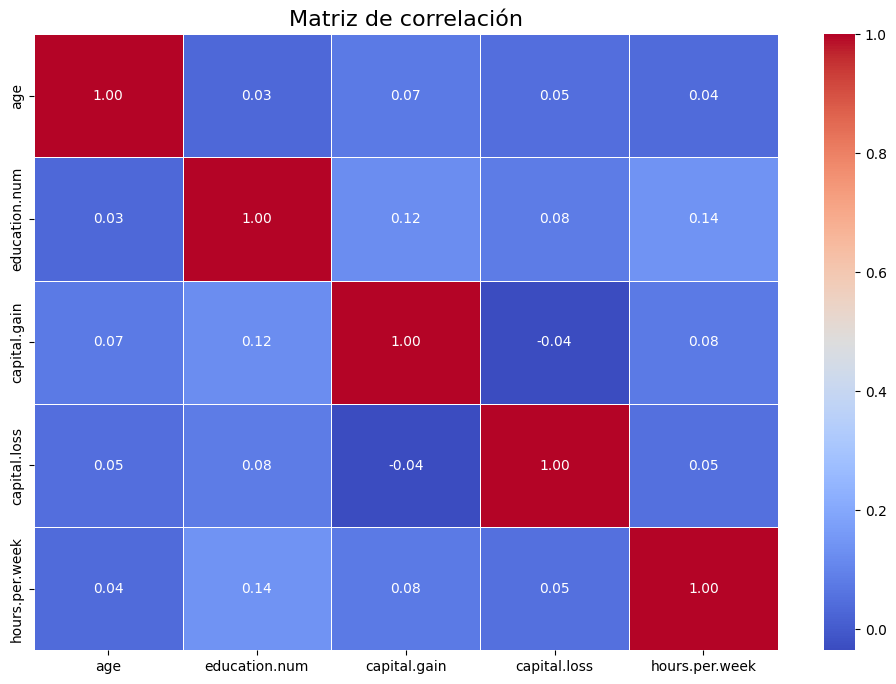

In [14]:
plt.figure(figsize=(12,8))

sns.heatmap(corr_matrix,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=0.5)

plt.title("Matriz de correlación", fontsize=16)
plt.show()

La matriz de correlación no nos proporciona mucha información. No la vamos a utilizar.

# Preprocesamiento del dataset

Convertimos la variable objetivo a una columna de 0 y 1 para llevar a cabo el problema de clasificación.

In [15]:
df['income'] = df['income'].str.strip() # Eliminamos los espacios en blanco que pueda haber
df['income'] = (df['income'] == '>50K').astype(int) # Con esto convertimos la columna a binaria

Separamos ahora la variable objetivo de las variables predictoras

In [16]:
X = df.drop('income', axis = 1)
y = df['income']

# Esto nos servirá para XGBoost. La dará más importancia a la clase minoritaria.
scale_pos_weight = (y == 0).sum() / (y == 1).sum()

Seleccionamos las columnas numéricas y las categóricas para la pipeline. Añadimos columns.tolist() porque necesitamos que los nombres estén en una lista.

In [17]:
num_col = X.select_dtypes(include=['int64']).columns.tolist()
cat_col = X.select_dtypes(include=['object']).columns.tolist()

Construimos las pipelines de preprocesamiento. Aplicaremos StandardScaler a las variables numéricas ya que para ciertos modelos (como SVM) es conveniente escalarlas. Por otro lado, aplicaremos OneHotEncoder a las variables categóricas y SimpleImputer() para inputar los '?' que detectamos antes por la clase más frecuente.

In [18]:
num_pipeline = Pipeline([
  ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy='most_frequent', missing_values='?')), # Por defecto missing_values=NaN
  ('encoder', OneHotEncoder(handle_unknown="ignore")),  # Con esto ignoramos datos desconocidos
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_col),
    ('cat', cat_pipeline, cat_col)
], sparse_threshold=0) # Añadimos esto para que no se creen matrices sparse, ya que KNN y NB pueden tener problemas

# Elección del modelo a través de validación cruzada anidada y ajuste y entrenamiento del modelo final

La validación cruzada anidada se basa en dos bucles:

El bucle interior ajusta los hiperparámetros del modelo. Una vez ajustados, se entrena el modelo con todo el conjunto de datos y se testea en el fold del bucle exterior. Esto devuelve una métrica. Repetimos el proceso tantas veces como folds hagamos en el bucle exterior. Notar dos cosas:
- El bucle interior es un GridSearchCV o un RandomizedSearchCV. Recordemos que ambos hacen una validación cruzada para el ajuste de hiperparámetros y luego entrenan el modelo final con todo el conjunto de datos y los hiperparámetros óptimos.
- La validación cruzada anidada no reporta unos hiperparámetros finales, ya que en cada fold del bucle exterior podemos obtener unos hiperparámetros distintos. Simplemente reporta una métrica fiel y honesta. Sirve también para quedarnos con un modelo, ya que la idea es hacer Nested CV con varios modelos.

Vamos a crear diccionarios donde las llaves serán los nombres de los modelos y los valores serán tuplas. El primer elemento de la tupla será el modelo y el segundo elemento será un diccionario con los hiperparámetros de dicho modelo.

In [19]:
grid_models_and_params = {
    'Regresión Logística' : (LogisticRegression(solver='liblinear', max_iter=1000), {'classifier__C': [0.1, 1.0]}), # C indica el parámetro de regularización, por defecto L2 (Ridge).

    'Knn' : (KNeighborsClassifier(), {'classifier__n_neighbors': [3, 5]}),

    'Random Forest' : (RandomForestClassifier(random_state=SEED),  {'classifier__n_estimators': [100, 200],
                                                                  'classifier__max_depth': [10, 20]}),

    'XGBoost': (XGBClassifier(eval_metric='logloss', scale_pos_weight=scale_pos_weight, n_jobs=-1, random_state=SEED),
                {'classifier__n_estimators': [100, 200],
                'classifier__learning_rate': [0.01, 0.05, 0.1],
                'classifier__max_depth': [5, 10]})}

Nota sobre SVM: Aunque Support Vector Machines (SVM) es un modelo potente, se ha omitido de la comparativa final. El modelo SVC con kernels no linealestiene una alta complejidad computacional, lo que resulta en tiempos de entrenamiento prohibitivos para este dataset de aproximadamente 30.000 muestras. Se priorizaron modelos más escalables como los ensembles de árboles.

In [20]:
# Definimos el bucle interior de la Nested CV
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

# Definimos el bucle exterior de la NestedCV
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Diccionarios para guardar las puntuaciones de la Nested CV
ncv_scores={}

# Iniciamos la NCV
for model_name, (model_object, grid) in grid_models_and_params.items():
    print(f'Evaluando {model_name}...')

    # Configuramos el pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model_object)
    ])

    # Configuramos el bucle interior. Este hará CV para seleccionar los mejores hiperparámetros y luego entrenará el modelo con todo el conjunto de datos
    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=grid,
        cv=inner_cv,
        scoring='f1',
        n_jobs=-1,
        #verbose=1,
        error_score='raise'
    )

    # Ejecutamos el bucle exterior. Vamos a pasar gs como nuestro estimador. 
    scores = cross_val_score(
        gs,
        X,
        y,
        cv=outer_cv,
        scoring='f1',
        n_jobs=-1,
        #verbose=1,
        error_score='raise'
    )

    # Guardamos los resultados
    ncv_scores[model_name] = scores

    # Mostramos los resultados
    print(f"Puntuaciones NCV: {np.round(scores, 4)}")
    print(f"F1 Media (Imparcial): {scores.mean():.4f} +/- {scores.std():.4f}")
    print('-'*40)


Evaluando Regresión Logística...


/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth

Puntuaciones NCV: [0.6589 0.6419 0.6553 0.6588 0.6674]
F1 Media (Imparcial): 0.6565 +/- 0.0083
----------------------------------------
Evaluando Knn...


/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


Puntuaciones NCV: [0.6331 0.6112 0.6247 0.6315 0.6447]
F1 Media (Imparcial): 0.6290 +/- 0.0110
----------------------------------------
Evaluando Random Forest...
Puntuaciones NCV: [0.6792 0.6559 0.6796 0.6858 0.6919]
F1 Media (Imparcial): 0.6785 +/- 0.0122
----------------------------------------
Evaluando XGBoost...
Puntuaciones NCV: [0.7154 0.7155 0.7154 0.7339 0.7296]
F1 Media (Imparcial): 0.7220 +/- 0.0081
----------------------------------------


--- Resumen del Rendimiento de NCV (F1-Score) ---
XGBoost                0.721980
Random Forest          0.678485
Regresión Logística    0.656470
Knn                    0.629007
dtype: float64


       Regresión Logística       Knn  Random Forest   XGBoost
count             5.000000  5.000000       5.000000  5.000000
mean              0.656470  0.629007       0.678485  0.721980
std               0.009293  0.012299       0.013642  0.009070
min               0.641900  0.611152       0.655918  0.715405
25%               0.655277  0.624681       0.679216  0.715429
50%               0.658841  0.631463       0.679582  0.715517
75%               0.658903  0.633078       0.685825  0.729619
max               0.667431  0.644659       0.691883  0.733929


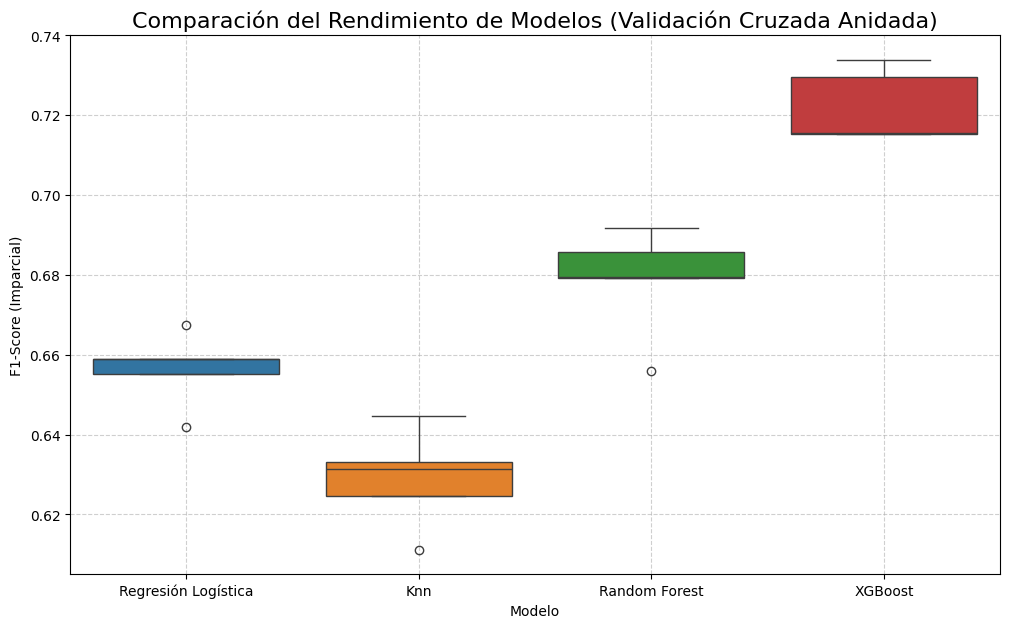

In [ ]:
# Visualización de los resultados de la NCV

ncv_results_df = pd.DataFrame(ncv_scores)

# Mostrar la media y std de forma ordenada
print("--- Resumen del Rendimiento de NCV (F1-Score) ---")
print(ncv_results_df.mean().sort_values(ascending=False))
print("\n")
print(ncv_results_df.describe())

# Crear un Boxplot
plt.figure(figsize=(12, 7))
sns.boxplot(data=ncv_results_df)
plt.title('Comparación del Rendimiento de Modelos (Validación Cruzada Anidada)', fontsize=16)
plt.ylabel('F1-Score (Imparcial)')
plt.xlabel('Modelo')
plt.grid(True, linestyle='--', alpha=0.6)

# Guaradamos la imagen en la carpeta images
plt.savefig('images/ncv_model_comparison.png', dpi=300, bbox_inches='tight')

plt.show()

In [34]:
# 1. Silenciar warnings de Python (Deprecations, Futures, etc.)
warnings.filterwarnings('ignore')

# 2. Silenciar warnings específicos de XGBoost y TensorFlow (si lo usaras)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

print("✅ Warnings silenciados. El output será mucho más limpio.")

✅ Warnings silenciados. El output será mucho más limpio.


In [35]:
# Desactivamos logs molestos
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 1. 🆕 MLFLOW: Configuramos el nombre del experimento
# Esto crea una "carpeta" virtual donde se guardarán todas las pruebas de este proyecto
# 1. Definimos que guarde los datos en la carpeta actual
uri_local = "file:./mlruns"

# 2. Forzamos a MLflow a usar esta ruta
mlflow.set_tracking_uri(uri_local)

# 3. Configuramos el experimento de nuevo
nombre_experimento = "Adult_Income_Experiment_V1"
mlflow.set_experiment(nombre_experimento)

print(f"✅ MLflow configurado correctamente en: {os.path.abspath('./mlruns')}")

# Una vez acabada la validación cruzada anidada seleccionamos y entrenamos el modelo final

# Sacamos el mejor modelo
best_model_name = max(ncv_scores, key=lambda name: ncv_scores[name].mean())
print(f'🚀 El modelo ganador según NCV es: {best_model_name}')
print('-'*60)
 
 # 2. Definimos la función objetivo 
def objective(trial):

    # 2. 🆕 MLFLOW: Iniciamos una "Run" (ejecución) para este trial específico
    # nested=True es vital porque estamos dentro de un bucle de Optuna
    with mlflow.start_run(nested=True):
    
        # A. Seleccionamos el modelo y sus hiperparámetros dinámicamente
        if best_model_name == 'Regresión Logística':
            params = {
                'C': trial.suggest_float('C', 0.01, 10.0, log=True),
                'solver': 'liblinear',
                'max_iter': 1000
            }
            model = LogisticRegression(**params) # Los ** sirven para desempaquetar el diccionario

        elif best_model_name == 'Knn':
            params = {
                'n_neighbors': trial.suggest_int('n_neighbors', 3, 20),
                'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
                'p': trial.suggest_categorical('p', [1, 2]) # Manhattan vs Euclidean
            }
            model = KNeighborsClassifier(**params) # Los ** sirven para desempaquetar el diccionario

        elif best_model_name == 'Random Forest':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                'max_depth': trial.suggest_int('max_depth', 5, 30),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'random_state': SEED,
                'n_jobs': -1
            }
            model = RandomForestClassifier(**params)

        elif best_model_name == 'XGBoost':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'gamma': trial.suggest_float('gamma', 0, 5),
                'scale_pos_weight': scale_pos_weight,
                'random_state': SEED,
                'n_jobs': -1,
                'eval_metric': 'logloss'
            }
            model = XGBClassifier(**params)

        # 3. 🆕 MLFLOW: Registramos los parámetros que estamos probando AHORA
        # Añadimos el nombre del modelo para saber cuál es
        mlflow.log_param("model_type", best_model_name)
        mlflow.log_params(params)

        # B. Pipeline y Evaluación
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        
        # Usamos F1 y cv=3 para velocidad. 
        # Si el modelo es muy rápido (LogReg), podrías subir cv=5.
        scores = cross_val_score(pipeline, X, y, cv=3, scoring='f1', n_jobs=-1)
        f1_mean = scores.mean()

        # 4. 🆕 MLFLOW: Registramos la métrica resultante (el score)
        mlflow.log_metric("f1_score", f1_mean)
        
        return f1_mean
    

# 3. Ejecutamos la optimización
print(f"⚡ Iniciando optimización bayesiana avanzada con Optuna y rastreo con MLflow para {best_model_name}...")
study = optuna.create_study(direction='maximize') # Usa TPE por defecto, que es un buen algoritmo de optimización bayesiana

# Damos más intentos a modelos complejos, menos a los simples
n_trials = 10 if best_model_name in ['XGBoost', 'Random Forest'] else 20

study.optimize(objective, n_trials=n_trials)

print("\n✅ Optimización completada.")
print(f"Mejor F1: {study.best_value:.4f}")
print(f"Mejores Params: {study.best_params}")

# 4. Reconstruir y entrenar modelo final
best_params = study.best_params

# Pequeño truco: Hay que volver a instanciar el objeto con los params fijos + los de optuna
if best_model_name == 'Regresión Logística':
    final_model_object = LogisticRegression(**best_params, solver='liblinear', max_iter=1000)
elif best_model_name == 'Knn':
    final_model_object = KNeighborsClassifier(**best_params)
elif best_model_name == 'Random Forest':
    final_model_object = RandomForestClassifier(**best_params, random_state=SEED, n_jobs=-1)
elif best_model_name == 'XGBoost':
    final_model_object = XGBClassifier(**best_params, random_state=SEED, n_jobs=-1, eval_metric='logloss', scale_pos_weight=scale_pos_weight)

final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', final_model_object)
])

final_pipeline.fit(X, y)
print("🎉 Modelo final entrenado y listo.")


✅ MLflow configurado correctamente en: /home/juanpe/personal/adult_income/mlruns
🚀 El modelo ganador según NCV es: XGBoost
------------------------------------------------------------
⚡ Iniciando optimización bayesiana avanzada con Optuna y rastreo con MLflow para XGBoost...

✅ Optimización completada.
Mejor F1: 0.6807
Mejores Params: {'n_estimators': 919, 'max_depth': 5, 'learning_rate': 0.01684014998296375, 'subsample': 0.8906562552640914, 'colsample_bytree': 0.642066833463454, 'gamma': 0.35581047369326435}
🎉 Modelo final entrenado y listo.


# Interpretabilidad de los resultados

Aquí tenemos que usar la librería shap

# Conclusiones

El objetivo del proyecto era identificar perfiles socioeconómicos con altos ingresos. Para ello se construyó una pipeline de preprocesamiento y se tomó una serie de modelos de clasificación para ver cual era más adecuado para nuestro problema: Knn, Regresión Logística, Random Forest y XGBoost. 

Se usó validación cruzada anidada (Nested Cross Validation) para la elección del modelo, donde el ganador fue XGBoost con un F1-Score de 0.7220. Una vez elegido el modelo, se ajustaron sus hiperparámetros y se entrenó el modelo usando Optuna, la cual realización una optimización bayesiana avanzada.


In [28]:
try:
    mlflow.end_run()
    print("✅ Se ha cerrado la ejecución activa anterior.")
except:
    print("ℹ️ No había ejecuciones activas.")

ℹ️ No había ejecuciones activas.
